In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# INS with real data

This notebook shows an idealized example of loose INS-LatLonObs integration.

## Import of the aircraft trajectory

Flight Radar 24 File

In [2]:
file = './data/EK97_2e28e528.csv'

In [3]:
# Read csv file
df = pd.read_csv(file,  sep=',', encoding='cp1252')
df.head()

,Timestamp,UTC,Callsign,Position,Altitude,Speed,Direction
0,1668056519,2022-11-10T05:01:59Z,UAE97,"25.254612,55.354511",0,3,120
1,1668056539,2022-11-10T05:02:19Z,UAE97,"25.25474,55.35429",0,3,120
2,1668056561,2022-11-10T05:02:41Z,UAE97,"25.254856,55.354084",0,1,120
3,1668056759,2022-11-10T05:05:59Z,UAE97,"25.25474,55.354301",0,4,120
4,1668056781,2022-11-10T05:06:21Z,UAE97,"25.254473,55.354782",0,7,120


In [4]:
dt = 0.01 # s

In [5]:
# Formatting the position
df[['lat', 'lon']] = df['Position'].str.split(pat=',', expand=True).astype(float)
# Index by UTC time
df.index = pd.to_datetime(df['UTC'])
df = df.sort_index()
# Removing unnecessary columns
df = df.drop(['Position', 'UTC','Timestamp', 'Callsign', 'Speed'], axis=1)
# Formatting of column names
df = df.rename(columns={"Altitude": "alt", "Direction": "h"})
# Oversampling and pchip interpolation
df.h = np.unwrap(df.h, period=360)
df = df.resample(str(dt*1000)+'ms').asfreq().interpolate(method='pchip')
# Flat flight
df['r'], df['p'] = 0, 0
# Removal of NaN
df = df.dropna()
df.head()

,alt,h,lat,lon,r,p
UTC,,,,,,
2022-11-10 05:01:59+00:00,0.0,120.0,25.254612,55.354511,0,0
2022-11-10 05:01:59.010000+00:00,0.0,120.0,25.254612,55.354511,0,0
2022-11-10 05:01:59.020000+00:00,0.0,120.0,25.254612,55.354511,0,0
2022-11-10 05:01:59.030000+00:00,0.0,120.0,25.254612,55.354511,0,0
2022-11-10 05:01:59.040000+00:00,0.0,120.0,25.254612,55.354511,0,0


In [6]:
#df.h.plot()

We also append 20 minutes of INS being at rest:

In [7]:
t_rest = np.arange(-1200, 0, dt)

In [8]:
df_rest = pd.DataFrame()
df_rest['lat'] = df.lat[0]*np.ones_like(t_rest)
df_rest['lon'] = df.lon[0]*np.ones_like(t_rest)
df_rest['alt'] = df.alt[0]*np.ones_like(t_rest)

df_rest['h'] = df.h[0]*np.ones_like(t_rest)
df_rest['p'] = df.p[0]*np.ones_like(t_rest)
df_rest['r'] = df.r[0]*np.ones_like(t_rest)

df = pd.concat([df_rest,df])

# Map of the flight 

In [9]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

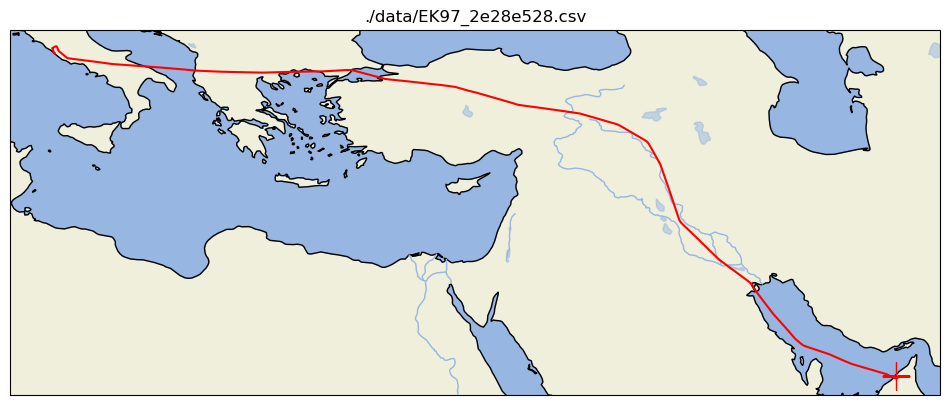

In [10]:
fig = plt.figure(figsize=(12,16))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_title(file)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.plot(df.lon, df.lat, color='red', transform=ccrs.PlateCarree())
ax.plot(df.lon[0], df.lat[0], transform=ccrs.PlateCarree(), markersize=20, marker='+', color='red')
plt.show()

# Computation of inertial increments

Run the simulation routine which will interpolate the trajectory and generate inertial readings:

In [11]:
from pyins import sim

In [12]:
traj_ref, gyro, accel = sim.from_position(dt, # period in the second
                                          df['lat'], df['lon'], df['alt'], # Position en deg, deg, m
                                          df['h'], df['p'], df['r']) # Attitude en deg

In [13]:
traj_ref.head()

,lat,lon,alt,VE,VN,VU,h,p,r
0,25.254612,55.354511,0.0,-1.865769e-07,5.861942e-08,-1.242650e-07,120.0,0.0,0.0
1,25.254612,55.354511,0.0,8.487400e-08,-2.643599e-08,5.604062e-08,120.0,0.0,0.0
2,25.254612,55.354511,0.0,1.599044e-08,-2.707308e-09,5.739116e-09,120.0,0.0,0.0
3,25.254612,55.354511,0.0,-7.791573e-08,2.988537e-08,-6.335284e-08,120.0,0.0,0.0
4,25.254612,55.354511,0.0,-3.818125e-09,-1.757887e-08,3.726476e-08,120.0,0.0,0.0


# Position, speed and attitude as a function of time

In [14]:
from helper import plot_traj

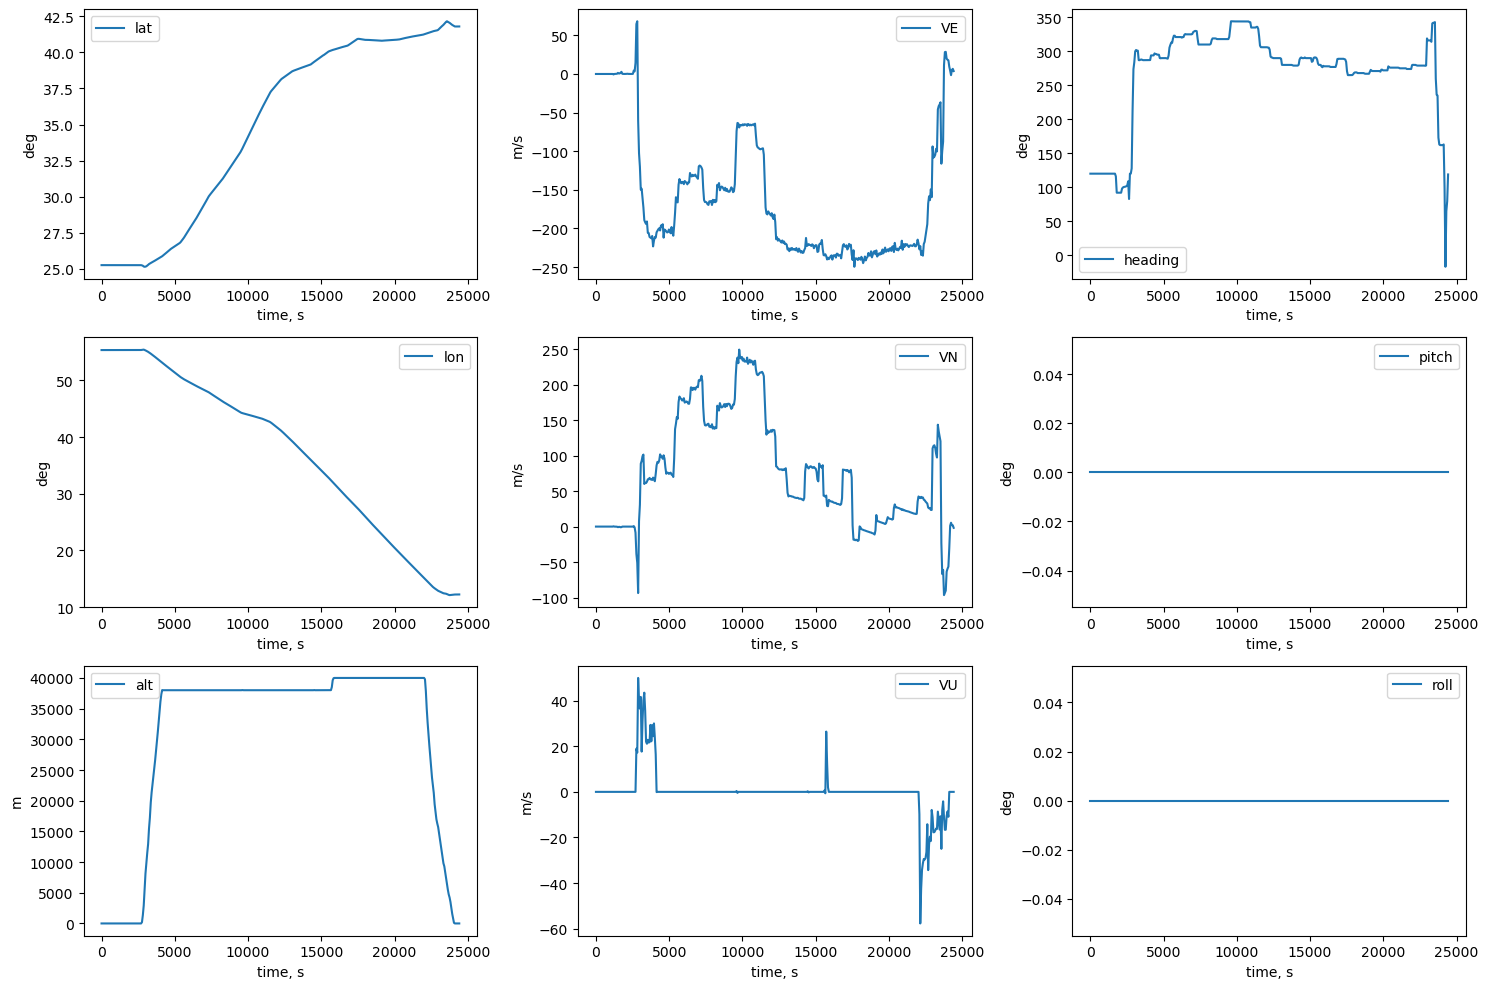

In [15]:
step_plot = int(60 / dt) 
plot_traj(dt, traj_ref, step_plot, coord_unit="deg")

# Inertial increments as a function of time

In [16]:
from helper import plot_inertial_readings

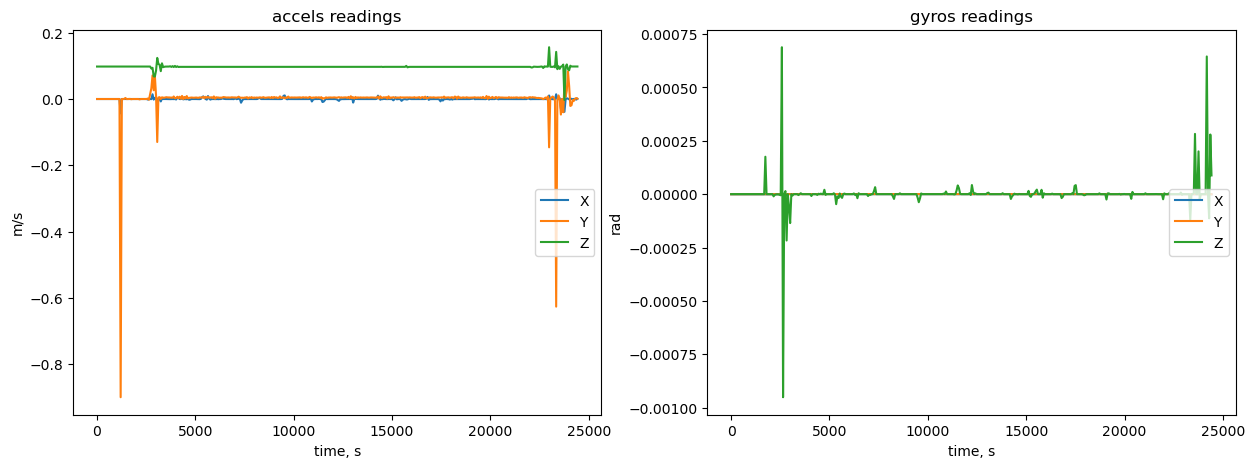

In [17]:
plot_inertial_readings(dt, gyro, accel, step_plot)

The final trajectory is drawn below, the initial point is marked with a cross.

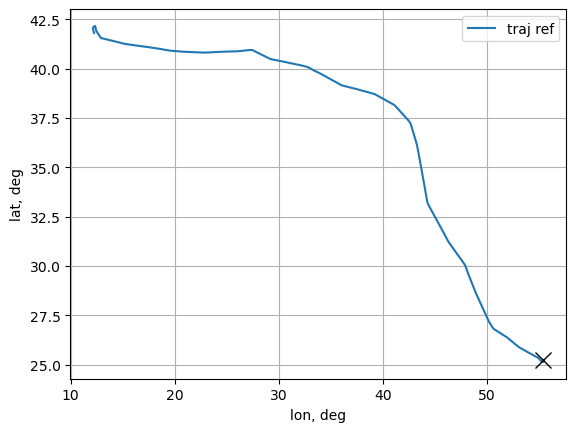

In [18]:
plt.plot(traj_ref.lon, traj_ref.lat, label='traj ref')
plt.plot(traj_ref.lon[0], traj_ref.lat[0], 'kx', markersize=12)
plt.grid()
plt.legend(loc='upper right')
plt.xlabel("lon, deg")
plt.ylabel("lat, deg")
plt.show()

## Integrating ideal data

Just to check that everything is correct we want to integrate the generated gyro and accel readings.

TODO 